In [1]:
from ultralytics import YOLO
import os
import yaml
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
data_dir = '/home/pepsi/dev_ws/mldl/Training/datasets/fire'
model = "yolov5n.pt"
classes = ['fire']
nc = len(classes)
yaml_file = 'data.yaml'

In [7]:
data = {
    'train': data_dir + '/train/',
    'val': data_dir + '/valid/',
    'test': data_dir + '/test/',
    'nc': nc,
    'names': classes
}

In [8]:
os.makedirs(data_dir, exist_ok=True)

with open(data_dir + '/' + 'data.yaml', 'wt') as fw:
    yaml.dump(data, fw)

In [9]:
with open(data_dir + '/' + 'data.yaml', 'rt') as ft:
    data = yaml.safe_load(ft)
    print(data)


{'names': ['fire'], 'nc': 1, 'test': '/home/pepsi/dev_ws/mldl/Training/datasets/fire/test/', 'train': '/home/pepsi/dev_ws/mldl/Training/datasets/fire/train/', 'val': '/home/pepsi/dev_ws/mldl/Training/datasets/fire/valid/'}


In [10]:
EPOCHS = 200
BATCH_SIZE = 32

In [ ]:
YOLO_model = YOLO(model).to(device)

YOLO_model.train(data=data_dir + '/' + yaml_file,
                 epochs=EPOCHS,

                 batch=BATCH_SIZE)

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.31M/5.31M [00:00<00:00, 51.0MB/s]


New https://pypi.org/project/ultralytics/8.3.94 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=/home/pepsi/dev_ws/mldl/Training/datasets/fire/data.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

E0000 00:00:1742531481.349491    5092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742531481.371673    5092 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742531481.522961    5092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742531481.523009    5092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742531481.523010    5092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742531481.523011    5092 computation_placer.cc:177] computation placer already registered. Please check linka

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 44.0MB/s]


AMP: checks passed ✅


train: Scanning /home/pepsi/dev_ws/mldl/Training/datasets/fire/train/labels.cache... 4688 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4688/4688 [00:00<?, ?it/s]
val: Scanning /home/pepsi/dev_ws/mldl/Training/datasets/fire/valid/labels.cache... 596 images, 0 backgrounds, 0 corrupt: 100%|██████████| 596/596 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.25G      1.808      2.846      1.674         49        640: 100%|██████████| 147/147 [00:52<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


                   all        596       1020       0.47      0.518      0.451      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200         5G      1.698      1.854       1.52         49        640: 100%|██████████| 147/147 [00:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


                   all        596       1020       0.66      0.619       0.64      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200         5G      1.714      1.617      1.527         42        640: 100%|██████████| 147/147 [00:46<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


                   all        596       1020      0.662       0.53       0.58      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200         5G      1.785      1.582      1.588         45        640: 100%|██████████| 147/147 [00:51<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


                   all        596       1020      0.654      0.607      0.651      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200         5G       1.76      1.467      1.566         53        640: 100%|██████████| 147/147 [00:47<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


                   all        596       1020      0.723      0.612      0.669       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200         5G      1.729      1.407      1.547         35        640: 100%|██████████| 147/147 [00:46<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        596       1020      0.812      0.675      0.776      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200         5G      1.718      1.341      1.518         28        640: 100%|██████████| 147/147 [00:51<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


                   all        596       1020       0.75      0.628      0.717      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200         5G      1.686      1.299        1.5         36        640: 100%|██████████| 147/147 [00:46<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        596       1020      0.782       0.69      0.776      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200         5G       1.67      1.262      1.496         38        640: 100%|██████████| 147/147 [00:45<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        596       1020      0.803      0.697      0.797      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200         5G      1.653      1.237      1.467         46        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        596       1020      0.806      0.709      0.802      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200         5G      1.638      1.201      1.458         38        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


                   all        596       1020      0.814      0.707      0.791      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200         5G      1.614      1.176      1.447         38        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        596       1020       0.79      0.678      0.796      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200         5G      1.616      1.165      1.449         35        640: 100%|██████████| 147/147 [00:46<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        596       1020      0.815      0.732      0.806      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200         5G      1.585      1.135      1.436         53        640: 100%|██████████| 147/147 [00:45<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

                   all        596       1020      0.815      0.726      0.808      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200         5G      1.571       1.12      1.419         42        640: 100%|██████████| 147/147 [00:45<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

                   all        596       1020      0.796      0.731      0.816       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200         5G      1.572       1.11      1.425         40        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

                   all        596       1020      0.855      0.714      0.823      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200         5G      1.554      1.082      1.406         43        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        596       1020      0.827      0.744      0.831      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200         5G      1.533      1.074      1.398         37        640: 100%|██████████| 147/147 [00:45<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

                   all        596       1020      0.831      0.748      0.831       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200         5G      1.526      1.065      1.391         40        640: 100%|██████████| 147/147 [00:55<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


                   all        596       1020      0.821      0.797      0.857      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200         5G      1.536      1.052        1.4         26        640: 100%|██████████| 147/147 [00:46<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all        596       1020      0.896       0.74      0.847      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200         5G      1.518      1.029      1.377         43        640: 100%|██████████| 147/147 [00:47<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        596       1020      0.814      0.744      0.826      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200         5G      1.511       1.02      1.378         43        640: 100%|██████████| 147/147 [00:45<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

                   all        596       1020      0.859      0.768      0.862      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200         5G      1.507      1.024      1.376         27        640: 100%|██████████| 147/147 [00:46<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        596       1020      0.851      0.741      0.843      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200         5G      1.485      1.008      1.356         42        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

                   all        596       1020      0.884      0.757      0.864      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200         5G      1.481     0.9939      1.355         30        640: 100%|██████████| 147/147 [00:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]

                   all        596       1020      0.813      0.797      0.864      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200         5G      1.467     0.9821      1.347         38        640: 100%|██████████| 147/147 [00:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        596       1020      0.808      0.811      0.871      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200         5G      1.486     0.9844      1.354         40        640: 100%|██████████| 147/147 [00:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


                   all        596       1020      0.834      0.796      0.865      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200         5G      1.464     0.9647      1.347         39        640: 100%|██████████| 147/147 [00:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

                   all        596       1020      0.865      0.781      0.875      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200         5G       1.46     0.9626      1.342         38        640: 100%|██████████| 147/147 [00:46<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

                   all        596       1020      0.865      0.782      0.868      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200         5G       1.46     0.9443      1.336         41        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        596       1020      0.842      0.792       0.88      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200         5G      1.451     0.9655       1.34         56        640: 100%|██████████| 147/147 [00:45<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        596       1020      0.819      0.805      0.864      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200         5G      1.449     0.9391       1.34         37        640: 100%|██████████| 147/147 [00:45<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

                   all        596       1020      0.859        0.8      0.886      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200         5G      1.443      0.923      1.326         45        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        596       1020      0.853      0.792      0.879       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200         5G      1.443     0.9342      1.331         37        640: 100%|██████████| 147/147 [00:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        596       1020      0.856      0.795      0.884      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200         5G      1.436       0.93      1.329         41        640: 100%|██████████| 147/147 [00:47<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        596       1020      0.873      0.807      0.883      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200         5G       1.43     0.9207      1.319         44        640: 100%|██████████| 147/147 [00:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        596       1020      0.877      0.807      0.889      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200         5G      1.416     0.9073      1.313         37        640: 100%|██████████| 147/147 [00:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

                   all        596       1020       0.85      0.808      0.891      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200         5G      1.423     0.9141      1.311         36        640: 100%|██████████| 147/147 [00:46<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

                   all        596       1020      0.875      0.787      0.895      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200         5G      1.416     0.9113      1.315         59        640: 100%|██████████| 147/147 [00:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

                   all        596       1020      0.878      0.825      0.904      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200         5G      1.407     0.8936      1.312         45        640: 100%|██████████| 147/147 [00:46<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all        596       1020      0.875      0.801      0.894      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200         5G      1.399     0.8841      1.299         35        640: 100%|██████████| 147/147 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

                   all        596       1020      0.872      0.818      0.897      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200         5G      1.412     0.8865      1.307         40        640: 100%|██████████| 147/147 [00:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

                   all        596       1020      0.866      0.825      0.899      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200         5G      1.383     0.8719      1.303         38        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        596       1020      0.876      0.833      0.905      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200         5G      1.383     0.8743      1.295         33        640: 100%|██████████| 147/147 [00:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        596       1020      0.906      0.825       0.91       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200         5G      1.369     0.8599       1.28         39        640: 100%|██████████| 147/147 [00:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        596       1020      0.879      0.817      0.902      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200         5G      1.369     0.8545      1.285         48        640: 100%|██████████| 147/147 [00:45<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        596       1020      0.871      0.837      0.904      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200         5G      1.374     0.8562      1.281         34        640: 100%|██████████| 147/147 [00:46<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

                   all        596       1020      0.878      0.838      0.909      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200         5G      1.374     0.8582      1.277         50        640: 100%|██████████| 147/147 [00:46<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        596       1020      0.888      0.816      0.907      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200         5G      1.359      0.845      1.278         41        640: 100%|██████████| 147/147 [00:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        596       1020      0.875      0.822      0.895      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200         5G      1.366     0.8525      1.278         36        640: 100%|██████████| 147/147 [00:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


                   all        596       1020      0.891      0.813      0.909      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200         5G      1.365     0.8539      1.281         49        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


                   all        596       1020      0.882      0.839       0.91      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200         5G      1.349     0.8301      1.265         51        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        596       1020      0.923       0.82       0.92      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200         5G      1.355     0.8353      1.267         44        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.888      0.842      0.917      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200         5G       1.35     0.8311      1.265         33        640: 100%|██████████| 147/147 [00:53<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


                   all        596       1020      0.903      0.834      0.909      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200         5G      1.348     0.8283      1.265         52        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


                   all        596       1020      0.895      0.829      0.913      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200         5G      1.343     0.8166      1.265         42        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020       0.92      0.828       0.92      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200         5G      1.324     0.8086      1.257         49        640: 100%|██████████| 147/147 [00:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


                   all        596       1020      0.901      0.835      0.915      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200         5G      1.329     0.8152      1.254         30        640: 100%|██████████| 147/147 [00:51<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        596       1020      0.916       0.84      0.925      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200         5G      1.346     0.8278      1.269         42        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020      0.902      0.842      0.917      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200         5G      1.324     0.7998      1.249         35        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.906      0.839      0.919      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200         5G      1.333     0.8039      1.257         47        640: 100%|██████████| 147/147 [01:04<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        596       1020      0.906      0.841      0.916      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200         5G      1.325     0.7875      1.247         37        640: 100%|██████████| 147/147 [01:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


                   all        596       1020      0.906      0.831      0.917      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200         5G       1.31     0.7886      1.243         60        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

                   all        596       1020      0.914      0.849      0.919      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200         5G      1.309     0.7905      1.237         34        640: 100%|██████████| 147/147 [00:51<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

                   all        596       1020      0.897      0.853      0.923      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200         5G      1.311     0.7874      1.246         42        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.913      0.851      0.924      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200         5G      1.313     0.7777      1.247         52        640: 100%|██████████| 147/147 [00:52<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


                   all        596       1020      0.889      0.868      0.929      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200         5G      1.318     0.7859      1.238         47        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.917      0.859      0.927      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200         5G      1.297      0.773      1.236         39        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        596       1020      0.892      0.843      0.918      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200         5G      1.292     0.7603      1.229         35        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.916      0.847      0.931      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200         5G      1.285     0.7627      1.226         43        640: 100%|██████████| 147/147 [00:53<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


                   all        596       1020      0.925      0.832      0.927      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200         5G      1.281     0.7632      1.228         30        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020      0.911      0.863      0.932       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200         5G      1.301     0.7724      1.243         46        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.926      0.846      0.928      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200         5G      1.284     0.7649       1.23         34        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        596       1020       0.93      0.855      0.931      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200         5G      1.279     0.7606      1.232         40        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


                   all        596       1020      0.915      0.873      0.935      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200         5G      1.277     0.7541      1.225         41        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        596       1020       0.92      0.858      0.933      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200         5G      1.264     0.7558      1.216         57        640: 100%|██████████| 147/147 [00:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020      0.921      0.867      0.932      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200         5G       1.28     0.7426      1.221         48        640: 100%|██████████| 147/147 [00:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020      0.926      0.875      0.935      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200         5G      1.266     0.7334      1.206         52        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        596       1020      0.923      0.862      0.936      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200         5G      1.277     0.7514      1.221         35        640: 100%|██████████| 147/147 [00:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.929      0.872       0.94        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200         5G      1.263     0.7283      1.212         58        640: 100%|██████████| 147/147 [00:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020       0.91      0.889      0.937      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200         5G      1.257     0.7312      1.211         44        640: 100%|██████████| 147/147 [00:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020      0.915      0.895       0.94      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200         5G      1.261     0.7296      1.204         39        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        596       1020      0.923      0.877       0.94      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200         5G      1.257      0.727      1.203         55        640: 100%|██████████| 147/147 [00:51<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020      0.941      0.879      0.944      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200         5G      1.246     0.7276      1.201         40        640: 100%|██████████| 147/147 [00:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020       0.91      0.892      0.944      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200         5G      1.243     0.7233      1.198         51        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


                   all        596       1020      0.925      0.863      0.941      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200         5G      1.243     0.7265      1.199         34        640: 100%|██████████| 147/147 [00:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        596       1020      0.923      0.864      0.938      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200         5G      1.239     0.7125      1.198         37        640: 100%|██████████| 147/147 [00:51<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.938      0.868      0.946      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200         5G      1.248     0.7187      1.201         40        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020       0.92      0.891      0.945      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200         5G      1.227     0.7003      1.191         36        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.935      0.889       0.95      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200         5G      1.234     0.7141      1.189         50        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


                   all        596       1020      0.928      0.885      0.947      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200         5G       1.23     0.7082       1.19         42        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


                   all        596       1020      0.943      0.877      0.941      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200         5G      1.232     0.6986       1.19         41        640: 100%|██████████| 147/147 [00:50<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.942       0.88      0.947      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200         5G      1.224     0.6927       1.19         35        640: 100%|██████████| 147/147 [00:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


                   all        596       1020       0.94      0.875      0.945      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200         5G      1.218     0.6922      1.186         34        640: 100%|██████████| 147/147 [00:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


                   all        596       1020      0.935       0.89      0.945      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200         5G      1.221     0.7044      1.189         45        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020       0.92      0.889      0.943       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200         5G      1.217     0.6908      1.182         43        640: 100%|██████████| 147/147 [01:04<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


                   all        596       1020      0.914      0.897      0.947       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200         5G      1.215     0.6956      1.181         32        640: 100%|██████████| 147/147 [00:50<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


                   all        596       1020      0.908       0.91      0.947       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200         5G      1.205     0.6803      1.179         57        640: 100%|██████████| 147/147 [00:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        596       1020      0.931      0.887      0.944       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200         5G       1.21     0.6838      1.183         42        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


                   all        596       1020       0.94      0.875      0.945      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200         5G      1.206     0.6863      1.182         47        640: 100%|██████████| 147/147 [00:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.922      0.877      0.945      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200         5G      1.207     0.6872       1.18         62        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

                   all        596       1020      0.935       0.88      0.948      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200         5G      1.202     0.6685      1.175         49        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020      0.938      0.885      0.948      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200         5G      1.185     0.6698      1.168         44        640: 100%|██████████| 147/147 [00:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        596       1020      0.947      0.884      0.948      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200         5G       1.19     0.6732       1.17         40        640: 100%|██████████| 147/147 [00:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        596       1020       0.95      0.883      0.953      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200         5G      1.187     0.6704      1.168         39        640: 100%|██████████| 147/147 [00:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.941      0.882      0.951       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200         5G      1.196     0.6797      1.179         32        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020       0.94      0.881      0.944      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200         5G       1.18     0.6705      1.167         49        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020      0.935      0.888      0.947      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200         5G      1.185     0.6668      1.166         59        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


                   all        596       1020      0.927      0.893      0.951      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200         5G      1.167     0.6657      1.158         39        640: 100%|██████████| 147/147 [00:55<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        596       1020      0.923      0.899      0.951       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200         5G      1.175     0.6591      1.159         55        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020      0.933      0.883      0.949      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200         5G      1.168     0.6534       1.16         41        640: 100%|██████████| 147/147 [00:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


                   all        596       1020      0.928      0.897       0.95      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200         5G      1.168     0.6539      1.158         39        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        596       1020      0.943      0.898      0.951      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200         5G      1.171     0.6568      1.158         40        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        596       1020      0.913       0.91       0.95      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200         5G      1.167     0.6488      1.151         46        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        596       1020      0.935      0.897       0.95      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      5.01G       1.16     0.6408      1.157         50        640: 100%|██████████| 147/147 [00:49<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


                   all        596       1020      0.932      0.891      0.949      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      5.01G      1.153     0.6423      1.154         40        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020       0.92      0.904      0.948      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      5.01G      1.155     0.6434      1.145         34        640: 100%|██████████| 147/147 [00:49<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.936      0.897      0.951      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      5.01G      1.159     0.6358      1.151         50        640: 100%|██████████| 147/147 [00:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


                   all        596       1020      0.928      0.898      0.949      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      5.01G      1.159     0.6452      1.152         55        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


                   all        596       1020      0.946      0.895      0.952      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      5.01G      1.145      0.639      1.142         33        640: 100%|██████████| 147/147 [00:49<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        596       1020      0.944      0.899      0.953      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      5.01G      1.147     0.6393      1.149         50        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


                   all        596       1020      0.935      0.901      0.952      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      5.01G      1.145     0.6387      1.148         53        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        596       1020      0.938      0.902      0.955      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      5.01G      1.139     0.6307      1.145         43        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        596       1020      0.937      0.903      0.957      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      5.01G      1.126     0.6208      1.137         67        640: 100%|██████████| 147/147 [00:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020      0.935      0.906      0.953      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      5.01G       1.14      0.628       1.14         41        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        596       1020      0.942      0.895      0.952      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      5.01G      1.133     0.6298       1.14         34        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020      0.937      0.901      0.953      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      5.01G      1.127     0.6242      1.139         51        640: 100%|██████████| 147/147 [00:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020       0.94      0.896      0.956       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      5.01G      1.132     0.6298      1.141         35        640: 100%|██████████| 147/147 [00:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


                   all        596       1020      0.918       0.91      0.952      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      5.01G      1.114     0.6196      1.128         32        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


                   all        596       1020      0.938      0.903      0.955      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      5.01G      1.111     0.6096       1.13         51        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


                   all        596       1020       0.95      0.899      0.957      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      5.01G      1.121     0.6155      1.133         37        640: 100%|██████████| 147/147 [00:55<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        596       1020       0.93      0.905      0.956      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      5.01G      1.121     0.6115      1.136         41        640: 100%|██████████| 147/147 [00:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020      0.938      0.904      0.957      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.01G      1.112     0.6117      1.128         47        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        596       1020      0.949      0.902      0.959      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      5.01G      1.112     0.6063      1.125         44        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        596       1020      0.945      0.909      0.959      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      5.01G      1.108     0.6101      1.126         36        640: 100%|██████████| 147/147 [00:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


                   all        596       1020      0.939      0.915      0.956      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      5.01G        1.1      0.604      1.119         42        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020      0.934      0.913      0.956      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      5.01G      1.108      0.599      1.123         41        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.938      0.914      0.956      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      5.01G      1.114     0.6124       1.13         33        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        596       1020       0.94      0.916      0.956      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      5.01G      1.097     0.6033      1.117         29        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        596       1020      0.936      0.908      0.956      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      5.01G      1.096     0.5987      1.116         52        640: 100%|██████████| 147/147 [00:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


                   all        596       1020      0.942      0.905      0.956      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      5.01G      1.091      0.591      1.117         44        640: 100%|██████████| 147/147 [00:50<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


                   all        596       1020      0.941      0.908      0.958      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      5.01G      1.085     0.5962      1.112         56        640: 100%|██████████| 147/147 [00:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        596       1020      0.942      0.908      0.958      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      5.01G      1.091     0.5941      1.123         48        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        596       1020      0.955      0.909      0.961      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.01G       1.09     0.5969      1.114         44        640: 100%|██████████| 147/147 [00:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

                   all        596       1020      0.954      0.912      0.962      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      5.01G       1.08     0.5836      1.109         49        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        596       1020      0.948      0.909      0.959      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      5.01G      1.082     0.5906      1.111         50        640: 100%|██████████| 147/147 [00:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        596       1020      0.943      0.919      0.959      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      5.01G      1.079     0.5894      1.113         46        640: 100%|██████████| 147/147 [00:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        596       1020      0.947      0.913       0.96       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      5.01G      1.071     0.5803      1.105         41        640: 100%|██████████| 147/147 [00:45<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        596       1020      0.946       0.91      0.958      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      5.01G      1.075     0.5758      1.109         32        640: 100%|██████████| 147/147 [00:45<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        596       1020      0.945      0.914      0.958      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      5.01G      1.062     0.5764        1.1         39        640: 100%|██████████| 147/147 [00:57<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        596       1020      0.949      0.909      0.958      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      5.01G      1.068     0.5834      1.109         32        640: 100%|██████████| 147/147 [00:52<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

                   all        596       1020      0.951      0.917      0.959      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      5.01G      1.063     0.5735      1.101         36        640: 100%|██████████| 147/147 [00:59<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

                   all        596       1020      0.946      0.918      0.961      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      5.01G      1.064     0.5704      1.102         53        640: 100%|██████████| 147/147 [00:45<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        596       1020      0.952      0.917       0.96      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      5.01G      1.057     0.5758      1.102         47        640: 100%|██████████| 147/147 [00:54<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

                   all        596       1020      0.951      0.916       0.96      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      5.01G      1.059     0.5768      1.102         50        640: 100%|██████████| 147/147 [00:46<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        596       1020      0.959      0.913      0.961      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      5.01G      1.046     0.5619      1.094         48        640: 100%|██████████| 147/147 [00:39<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        596       1020      0.954      0.913      0.962      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      5.01G      1.056     0.5677      1.101         52        640: 100%|██████████| 147/147 [00:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        596       1020      0.955       0.91      0.961      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      5.01G      1.042     0.5656      1.093         30        640: 100%|██████████| 147/147 [00:47<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

                   all        596       1020      0.952      0.911      0.962      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      5.01G      1.041     0.5621      1.092         34        640: 100%|██████████| 147/147 [00:47<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]

                   all        596       1020      0.956      0.907      0.961      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      5.01G      1.046     0.5599      1.093         46        640: 100%|██████████| 147/147 [00:41<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


                   all        596       1020      0.953      0.913      0.962      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.01G      1.046     0.5664      1.093         29        640: 100%|██████████| 147/147 [00:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

                   all        596       1020      0.944      0.919      0.962      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      5.01G      1.023      0.554      1.079         17        640: 100%|██████████| 147/147 [00:46<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        596       1020      0.949       0.92      0.961      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.01G      1.031     0.5597      1.088         43        640: 100%|██████████| 147/147 [00:38<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        596       1020      0.951      0.917      0.961      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      5.01G      1.029     0.5508      1.085         37        640: 100%|██████████| 147/147 [00:38<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        596       1020      0.948      0.919      0.961      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      5.01G       1.03     0.5531      1.083         56        640: 100%|██████████| 147/147 [00:38<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        596       1020       0.95      0.918      0.961      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      5.01G      1.024     0.5505      1.083         44        640: 100%|██████████| 147/147 [00:38<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        596       1020      0.952      0.917      0.961      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      5.01G      1.027     0.5517      1.079         54        640: 100%|██████████| 147/147 [00:41<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

                   all        596       1020      0.951      0.922      0.961      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.01G      1.017     0.5466      1.081         37        640: 100%|██████████| 147/147 [00:44<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        596       1020      0.953      0.916      0.961      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      5.01G       1.01     0.5403      1.079         47        640: 100%|██████████| 147/147 [00:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        596       1020      0.944      0.925      0.961      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      5.01G      1.018     0.5448       1.08         46        640: 100%|██████████| 147/147 [00:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

                   all        596       1020      0.943      0.927      0.961      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      5.01G      1.008     0.5425      1.083         38        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

                   all        596       1020      0.951      0.924      0.961      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      5.01G      1.019     0.5452      1.077         58        640: 100%|██████████| 147/147 [00:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

                   all        596       1020      0.952      0.919      0.962      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      5.01G      1.005     0.5403      1.074         36        640: 100%|██████████| 147/147 [00:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

                   all        596       1020      0.957      0.919      0.962      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      5.01G      1.007     0.5377      1.076         37        640: 100%|██████████| 147/147 [00:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

                   all        596       1020       0.96      0.919      0.962      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      5.01G     0.9995     0.5382      1.077         42        640: 100%|██████████| 147/147 [00:44<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

                   all        596       1020      0.953      0.925      0.962      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      5.01G     0.9847     0.5349      1.068         49        640: 100%|██████████| 147/147 [00:53<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

                   all        596       1020      0.958      0.922      0.963      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      5.01G     0.9955     0.5278       1.07         36        640: 100%|██████████| 147/147 [00:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

                   all        596       1020      0.956      0.923      0.962      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      5.01G       0.99     0.5327      1.071         39        640: 100%|██████████| 147/147 [00:42<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        596       1020      0.955      0.921      0.962      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.01G     0.9985     0.5337      1.067         51        640: 100%|██████████| 147/147 [00:41<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        596       1020      0.956      0.921      0.963      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      5.01G     0.9892     0.5319      1.067         36        640: 100%|██████████| 147/147 [00:38<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        596       1020      0.959      0.919      0.962      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      5.01G     0.9793     0.5226      1.062         50        640: 100%|██████████| 147/147 [00:46<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


                   all        596       1020      0.958      0.919      0.962      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      5.01G     0.9871     0.5268      1.067         34        640: 100%|██████████| 147/147 [00:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

                   all        596       1020      0.949      0.922      0.962      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      5.01G     0.9812     0.5237      1.064         39        640: 100%|██████████| 147/147 [00:44<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        596       1020      0.952      0.919      0.962      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      5.01G     0.9757      0.518      1.062         48        640: 100%|██████████| 147/147 [00:50<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        596       1020       0.95      0.923      0.962      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      5.01G     0.9745     0.5175      1.059         39        640: 100%|██████████| 147/147 [00:47<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        596       1020      0.951       0.92      0.961      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      5.01G     0.9707     0.5206      1.059         41        640: 100%|██████████| 147/147 [00:48<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

                   all        596       1020      0.951       0.92      0.962      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      5.01G     0.9744     0.5162      1.064         42        640: 100%|██████████| 147/147 [00:44<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

                   all        596       1020      0.951      0.921      0.961      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      5.01G      0.967     0.5144      1.056         58        640: 100%|██████████| 147/147 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        596       1020      0.951       0.92      0.962      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      5.01G      0.956     0.5091      1.052         49        640: 100%|██████████| 147/147 [00:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        596       1020      0.956       0.92      0.962      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      5.01G       0.97     0.5175      1.058         51        640: 100%|██████████| 147/147 [00:39<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        596       1020      0.955      0.921      0.962      0.668


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      5.01G     0.9356     0.4601      1.037         28        640: 100%|██████████| 147/147 [00:39<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        596       1020      0.951      0.923      0.962      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      5.01G     0.9132     0.4463      1.034         28        640: 100%|██████████| 147/147 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        596       1020       0.95      0.926      0.963      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      5.01G     0.9068      0.446       1.03         22        640: 100%|██████████| 147/147 [00:41<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        596       1020      0.951      0.926      0.962      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      5.01G     0.8967     0.4386      1.029         29        640: 100%|██████████| 147/147 [00:44<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        596       1020      0.951      0.926      0.962       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      5.01G     0.8896     0.4321      1.019         24        640: 100%|██████████| 147/147 [00:39<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        596       1020      0.952      0.926      0.962       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      5.01G     0.8856     0.4327      1.019         25        640: 100%|██████████| 147/147 [00:38<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        596       1020      0.953      0.926      0.962      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      5.01G     0.8865     0.4312      1.016         26        640: 100%|██████████| 147/147 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        596       1020      0.954      0.926      0.962      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      5.01G     0.8777     0.4269      1.013         24        640: 100%|██████████| 147/147 [00:41<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        596       1020      0.953      0.926      0.962      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      5.01G     0.8804     0.4284      1.016         25        640: 100%|██████████| 147/147 [00:41<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        596       1020      0.955      0.925      0.962      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      5.01G     0.8745     0.4266      1.011         17        640: 100%|██████████| 147/147 [00:42<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        596       1020      0.955      0.925      0.963      0.673



200 epochs completed in 2.980 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 5920MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


                   all        596       1020      0.956      0.926      0.963      0.673
Speed: 0.4ms preprocess, 2.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4ca69262a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

best_model = YOLO('/home/pepsi/dev_ws/deeplearning-repo-2/src/video_ai_server/model/fire_detect_model.pt').to(device)
metrics = best_model.val()

log_path = "/home/pepsi/dev_ws/mldl/Training/runs/detect/train/results.csv"

df = pd.read_csv(log_path)
df.head()

YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning /home/pepsi/dev_ws/mldl/Training/datasets/fire/valid/labels.cache... 596 images, 0 backgrounds, 0 corrupt: 100%|██████████| 596/596 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:06<00:00,  6.26it/s]


                   all        596       1020      0.955      0.926      0.963      0.673
Speed: 1.0ms preprocess, 4.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,61.2005,1.80824,2.84610,1.67440,0.47031,0.51765,0.45146,0.18679,1.73945,2.60889,1.59586,0.003311,0.003311,0.003311
1,2,113.7060,1.69756,1.85434,1.51954,0.66043,0.61863,0.63997,0.31572,1.68133,1.60873,1.54816,0.006611,0.006611,0.006611
2,3,164.3740,1.71428,1.61690,1.52675,0.66160,0.53039,0.58026,0.26523,1.81466,1.78804,1.64155,0.009879,0.009879,0.009879
3,4,219.7600,1.78528,1.58244,1.58822,0.65365,0.60686,0.65064,0.29179,1.71885,1.55390,1.54272,0.009851,0.009851,0.009851
4,5,271.0490,1.75966,1.46682,1.56650,0.72284,0.61176,0.66864,0.31021,1.69987,1.58822,1.57799,0.009802,0.009802,0.009802


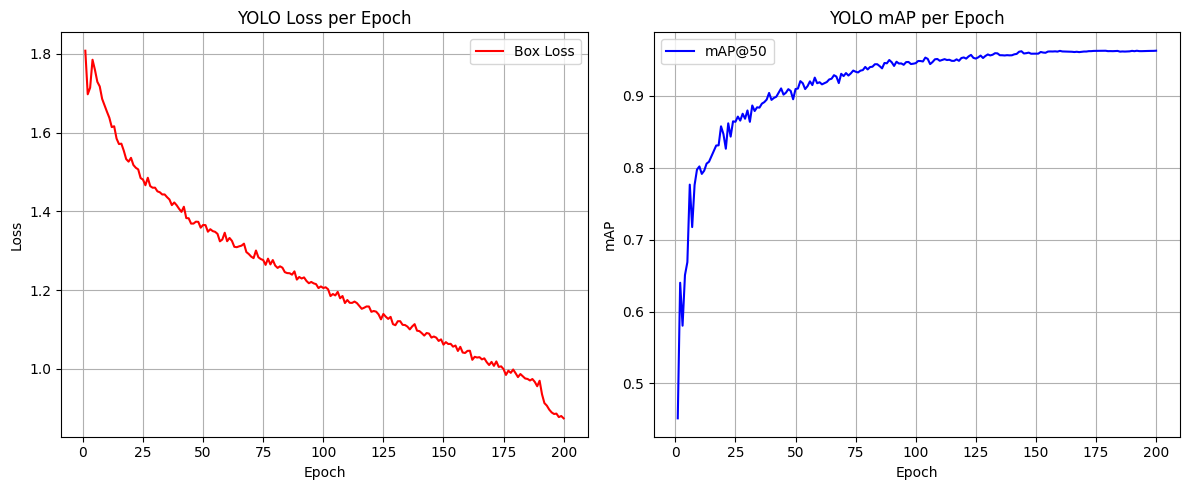

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLO Loss per Epoch')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='blue')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('YOLO mAP per Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [4]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        blur_frame = cv2.GaussianBlur(frame, (5, 5), 0)

        # 모델 예측
        results = best_model(blur_frame)

        if len(results) > 0:  # 리스트가 비어있는지 확인
            result = results[0]  # 첫 번째 결과 가져오기
            
            if hasattr(result, "boxes") and result.boxes is not None:
                boxes = result.boxes.xyxy.cpu().numpy()  # 바운딩 박스 좌표
                confs = result.boxes.conf.cpu().numpy()  # 신뢰도
                cls_ids = result.boxes.cls.cpu().numpy()  # 클래스 ID
                
                for box, conf, cls_id in zip(boxes, confs, cls_ids):
                    if conf > 0.5:  # 신뢰도 50% 이상만 표시
                        x1, y1, x2, y2 = map(int, box)  # 바운딩 박스 좌표
                        label = f"{result.names[int(cls_id)]} {conf:.2f}"  # 라벨 및 신뢰도

                        # 바운딩 박스 그리기
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                        # 라벨 텍스트 추가
                        cv2.putText(frame, label, (x1, y1 - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.imshow("test_frame", frame)

        if cv2.waitKey(1) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 31.6ms
Speed: 1.4ms preprocess, 31.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 12.1ms
Speed: 2.7ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 10.4ms
Speed: 4.8ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 11.6ms
Speed: 4.4ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 10.3ms
Speed: 6.0ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 9.1ms
Speed: 4.6ms preprocess, 9.1ms infer